# Stable Diffusion

**Prérequis**:
- Connaitre les U-Net
- Utiliser Google Colab ou un GPU pour l'entrainement
- Connaitre les transformers (optionnel)

## Ca sert à quoi en fait ?

Bienvenue à l'un des TP les plus attendus depuis un an: le TP de diffusion stable. Avant de le commencer, je vous conseil de faire celui sur les transformers, car il vous sera utile pour comprendre le fonctionnement de certaines parties du modèle. Si toutefois vous voulez commencer par ce TP, je vous indiquerai les partie où vous pourrez trouver des informations sur les transformers.

Cette architecture est très utilisée, notamment dans les modèles de génération d'images. Beaucoup de jeux de poids sont disponibles en ligne, et il est possible de générer des images de haute qualité en utilisant ces modèles.

En voici un exemple avec les poids du modèle Anything v3.0 :

- 1girl, brown hair, green eyes, colorful, autumn, cumulonimbus clouds, lighting, blue sky, falling leaves, garden

![out-0.png](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/anime1.png)

- 1boy, medium hair, blonde hair, blue eyes, bishounen, colorful, autumn, cumulonimbus clouds, lighting, blue sky, falling leaves, garden

![out-0-2.png](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/anime2.png)

Générer des images à partir d'un texte est l'utilisation la plus connue, mais cette architecture permet également de faire d'autres choses comme la modification d'images (image to image translation) ou la modification d'une partie de l'image (inpainting).

Exemple de image to image translation :

- input
    - ![Sans titre.png](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/imgtoimg.png)
    - Prompt : A fantasy landscape, trending on artstation

- output
    - ![Sans titre-2.png](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/imgtoimg2.png)

Ces images sont certes magnifiques, mais demandent beaucoup de ressources pour être générées. Il est donc préférable de les générer sur un GPU, ou de les générer sur un serveur distant. Comme je souhaite que ce TP soit facilement faisable par tout le monde, bien qu'il soit certainement l'un des plus compliqué, nous nous contenterons de générer des images du dataset MNIST (oui je sais c'est décevant, mais tout le monde n'a pas une DGX à disposition...).

De plus, comme ce TP est sûrement l'un des plus compliqué, la correction sera mise à disposition pour que vous puissiez vous corriger vous même.

## Principe de base



<center>
<img src='https://i.ibb.co/n0x7hN7/ddpm.png' alt="drawing" width= '900px'/>
</center>

Le modèle est composé de deux parties principales :
- le générateur et le bruiteur. Le générateur est un U-Net qui prend en entrée l'étape de diffusion et l'image bruitée, et devine le bruit présent dans l'image. On peut alors le retirer pour obtenir une image à l'étape précedente.
- Le bruiteur est un programme qui prend en entrée l'image d'origine et génère le bruit. Le générateur est entraîné à générer une image débruitée à partir de l'image bruitée.

L'idée pour entrainer ce genre de model, c'est de prendre une image à une étape de bruitage $t_i$ et de la débruitée pour obtenir l'image à l'étape $t_{i-1}$. On peut alors  la comparer à l'image à l'étape $t_{i-1}$ pour calculer l'erreur et répéter cette opération à différentes étapes de bruittage et sur différentes images pour entraîner le UNet.

Pour plus de détails, n'hésitez pas à lire ce [papier de recherche](https://arxiv.org/pdf/2006.11239).

## Structure du modèle

Dans les fait, on n'applique pas le U-Net sur l'image elle-même, mais dans un espace latent. Cet espace latent est généré par un encodeur, et l'image finale est obtenue en décodant ce vecteur latent. Cela permet de séparer la génération de l'image en deux étapes, et de réduire la complexité du modèle. Pour ce TP, nous n'utiliserons pas cet encodeur car le modèle sera plus petit et plus simple à entraîner. Pour des images de plus grande taille, il est cependant nécessaire de l'utiliser.

L'architecture du modèle globale est la suivante :

![image.png](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/architecture_globale.png)

Mais avec cette simplification, il suffit de faire la même chose sans être dans un espace latent.

Alors je sais, cette image fait un peu peur. Mais ne vous inquiétez pas, on va y aller étape par étape pour comprendre comment tout cela fonctionne.

Le concept central du processus est de commencer avec une image claire. Sur un nombre d'étapes spécifié, noté ‘T’, une petite quantité de bruit est progressivement introduite, suivant une distribution gaussienne. Voyons de plus près comment ce processus se déroule.

![1_QPPh9Zipx2MOoCsPQaPEgA.webp](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/diffusion_step.png)



## Implémentation

### Import des librairies

On doit d'abord importer les librairies nécessaires pour implémenter le modèle (sans blague...).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from tqdm import tqdm
from abc import abstractmethod

# Pour avoir les mêmes résultats
torch.manual_seed(0)
np.random.seed(0)

### Creation du U-Net

#### Structure

Le modèle principal sera le U-net. Cependant, celui-ci est un peu particulier et contiendra des couches résiduelles et des couches d'attention.

On va donc créer une classe pour chaque bloc de ce U-Net. On va ensuite les assembler pour obtenir le modèle final.

La classe de base que l'on va completer au fur et à mesure est la suivante :

In [ ]:
#couche résiduelle: on ajoute x et la conv2D(x)
class U_Net(nn.Module):
    def __init__(self,
                in_channels=3,
                model_channels=128,
                out_channels=3,
                num_res_blocks=2,
                attention_resolutions=(8, 16),
                dropout=0,
                channel_mult=(1, 2, 2, 2),
                conv_resample=True,
                num_heads=4,
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

#### Time Embedding

Le time embedding est une couche qui va ajouter une dimension temporelle à l'entrée. Cela permet de donner au modèle une idée de la progression de l'image.

L'idée est identique au positional embedding des transformers, mais pour le temps. On va donc utiliser une couche de sinus et de cosinus pour encoder le temps.

L'objectif est de donner, pour une étape t, un vecteur de dimension d. Ce vecteur est calculé de la manière suivante, pour d = 4 :

$$
\begin{align*}
\text{embedding}(t) &= \left[ \cos\left(\frac{t}{10000^{0}}\right), \cos\left(\frac{t}{10000^{1/2}}\right), \sin\left(\frac{t}{10000^{0}}\right), \sin\left(\frac{t}{10000^{1/2}}\right) \right]
\end{align*}
$$

De manière générale, pour une dimension d, on a la formule suivante où $i$ va de $0$ à $d/2$ :

$$
\begin{align*}
\text{embedding}(t) &= \left[ \cos\left(\frac{t}{10000^{0}}\right), \ldots, \cos\left(\frac{t}{10000^{\frac{2i}{d}}}\right), \ldots, \cos\left(\frac{t}{10000}\right), \sin\left(\frac{t}{10000^{0}}\right) \ldots, \sin\left(\frac{t}{10000^{\frac{2i}{d}}}\right), \ldots, \sin\left(\frac{t}{10000}\right),  \right]
\end{align*}
$$

In [ ]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """Crée un embedding des timesteps pour les transformer en une représentation continue.

    Args:
        timesteps (torch.Tensor): Tenseur de taille (seq_len) contenant les t
        dim (int): Dimension de l'embedding
        max_period (int, optional): Période maximale. Defaults to 10000.

    Returns:
        torch.Tensor: Tenseur de taille (seq_len, dim) contenant l'embedding
    """
    half = dim // 2
    # A remplir pour calculer embedding qui contient l'ensemble des embedding(t) pour t dans timesteps
    embeddings = []
    for t in timesteps:
        embedding_cos = []
        embedding_sin = []
        for i in range(half):
            embedding_cos.append(torch.cos(t / (max_period ** (2 * i / dim))))
            embedding_sin.append(torch.sin(t / (max_period ** (2 * i / dim))))
        embeddings.append(embedding_cos + embedding_sin)

    # Si la dimension est impaire, on rajoute une dimension de 0
    if dim % 2:
        embeddings.append([0] * timesteps.shape[0])

    return torch.tensor(embeddings).to(device=timesteps.device)

print(timestep_embedding(torch.arange(10).float(), 256)[1][0:9])
print(timestep_embedding(torch.arange(10).float(), 256).shape)

tensor([0.5403, 0.5974, 0.6479, 0.6925, 0.7318, 0.7662, 0.7965, 0.8229, 0.8460])
torch.Size([10, 256])


Vous devriez obtenir en sortie un vecteur de dimension ``(10, 256)`` et dont les valeurs du print sont ``[0.5403, 0.5974, 0.6479, 0.6925, 0.7318, 0.7662, 0.7965, 0.8229, 0.8460]``.

On ajoute alors une deuxième couche pour transformer ce vecteur en un vecteur de dimension d_time_emb (qui sera la dimension de l'embedding temporel).
Cette couche est une couche lineaire (de ``dim`` vers ``d_time_emb``), suivie d'une activation SiLU (apparemment c'est mieux) puis d'une autre couche linéaire. On peut alors obtenir l'embedding temporel de l'étape t.

In [ ]:
class Time_Embedding(nn.Module):
    def __init__(self, dim: int, d_time_emb: int):
        super().__init__()
        self.dim = dim
        self.layers = nn.Sequential(
            nn.Linear(dim, d_time_emb),
            nn.SiLU(),
            nn.Linear(d_time_emb, d_time_emb)
            )

    def forward(self, time_steps: torch.Tensor):
        time_steps = timestep_embedding(time_steps, self.dim)
        return self.layers(time_steps)

Le code suivant permet de tester cette couche.

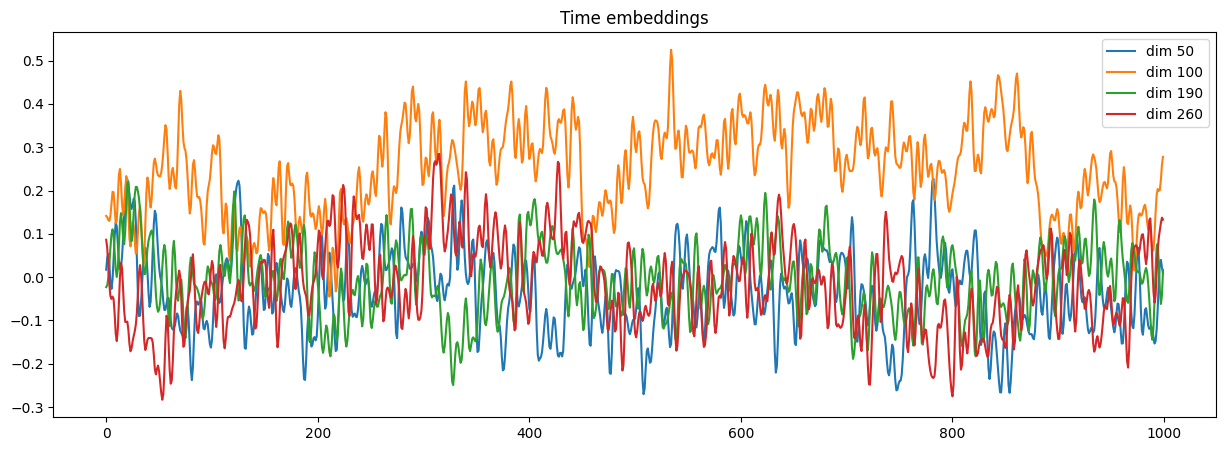

In [ ]:
"""
Test sinusoidal time step embeddings
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
te = Time_Embedding(128, 512)(torch.arange(1000).float())
plt.plot(np.arange(1000), te[:, [50, 100, 190, 260]].detach().numpy())
plt.legend(["dim %d" % p for p in [50, 100, 190, 260]])
plt.title("Time embeddings")
plt.show()

L'objectif est d'avoir ce résultat en sortie (en relançant toutes les cellules précédentes dans l'ordre) :
![image.png](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/time_emb.png)

Maintenant, on peut ajouter cette couche à notre modèle.

In [ ]:
class U_Net(nn.Module):
    def __init__(self,
                in_channels=3,
                model_channels=128,
                out_channels=3,
                num_res_blocks=2,
                attention_resolutions=(8, 16),
                dropout=0,
                channel_mult=(1, 2, 2, 2),
                conv_resample=True,
                num_heads=4,
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # Time embedding layer
        d_time_emb = model_channels * 4
        self.time_embed = Time_Embedding(model_channels, d_time_emb)

#### Bloc d'Attention

Nous allons maintenant nous intéresser au bloc d'attention. Pour mieux comprendre son fonctionnement, je vous conseil de faire le TP sur les transformers. Cela vous permettra de comprendre comment fonctionne l'attention. Je laisse prérempli le code de la couche d'attention, mais je vous conseil de le comprendre avant de passer à la suite.

In [ ]:
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Attention block with shortcut

        Args:
            channels (int): channels
            num_heads (int, optional): attention heads. Defaults to 1.
        """
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B * self.num_heads, -1, H * W).chunk(3, dim=1)

        # Echelle par laquelle multiplier les valeurs de q et k pour éviter les explosions
        # Elle correspond au 1 / math.sqrt(self.d_model) du TP sur les transformers
        scale = 1.0 / math.sqrt(math.sqrt(C // self.num_heads))

        # Equivalent au score du TP sur les transformers
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)

        # Equivalent à l'output du TP sur les transformers
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

#### Bloc résiduel

Maintenant, nous allons faire le bloc résiduel. Celui-ci est un peu particulier, car il doit prendre en compte l'embedding temporel. On va donc créer une classe qui va gérer cela pour nous.

In [ ]:
class TimestepBlock(nn.Module): #pas toucher
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t):
        """
        Apply the module to `x` given `t` timestep embeddings.
        """
        pass


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t)
            else:
                x = layer(x)

        # Si le module est un TimestepBlock, on lui passe t en argument, sinon on lui passe juste x
        return x

On peut alors implémenter le bloc résiduel, qui hérietera de la classe de base.

In [ ]:
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),   # Normalisation
            nn.SiLU(),    # Activation SiLU
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)    # Convolution 3x3 avec padding 1 de in_channels vers out_channels
        )

        # couche pour projeter les embeddings temporels dans l'espace des features (activation SiLU suivie de time_channels -> out_channels grâce à une couche linéaire)
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),    # Normalisation
            nn.SiLU(),   # Activation SiLU
            nn.Dropout(dropout),   # Dropout
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1) # Convolution 3x3 avec padding 1 de out_channels vers out_channels /!\ in_channels vers out_channels dans docu de base, mais c'est absurde
        )

        if in_channels != out_channels: # Si les dimensions ne correspondent pas, on rajoute une couche de convolution 1x1 pour adapter les dimensions
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

#### Bloc de DownSample et UpSample

Maintenant on va créer le bloc de downsample. Celui-ci a pour objectif de réduire la taille de l'image tout en augmentant le nombre de canaux. Celui-ci va être très simple, car il va simplement appliquer une convolution 3x3 avec un stride de 2 et un padding de 1 dans le cas où on utilise la convolution, ou un average pooling 2x2 sinon.

In [ ]:
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.layer = nn.Conv2d(channels, channels, kernel_size = 3, stride = 2, padding = 1)
        else:
            self.layer = nn.AveragePooling2d(kernel_size = 2)

    def forward(self, x):
        return self.layer(x)

De même pour le bloc de upsample où on va utiliser ``F.interpolate`` avec ``mode="nearest"`` pour augmenter la taille de l'image, et une convolution 3x3 si on utilise la convolution (padding de 1).

In [ ]:
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size = 3, padding = 1)

    def forward(self, x):
        x = F.interpolate(x, mode = "nearest", scale_factor = 2)
        if self.use_conv:
            x = self.conv(x)
        return x

#### Le U-Net : ENFIN !

Ca y est, on peut remplir le U-Net. Pour cela, on va utiliser les blocs que l'on a créé précédemment. Attention, ce modèle est long avec beaucoup d'hypers paramètres, donc il est possible que vous ayez des erreurs. Si c'est le cas, n'hésitez pas à regarder la correction. Si vous n'arrivez pas à assembler toutes ses briques ensembles ce n'est pas grave, l'important est de comprendre comment fonctionne chaque partie. Cela m'a pris des mois à tout comprendre donc prenez surtout le temps de comprendre la correction.

Voici l'architecture du U-Net (il ne faut pas oublier les shortcuts classiques du U-Net) :
````
===============================================================================================
Layer (type:depth-idx)                        Output Shape              Param #
===============================================================================================
UNetModel                                     [2, 3, 64, 64]            --
├─Time_Embedding: 1-1                         [2, 512]                  --
│    └─Sequential: 2-1                        [2, 512]                  --
│    │    └─Linear: 3-1                       [2, 512]                  66,048
│    │    └─SiLU: 3-2                         [2, 512]                  --
│    │    └─Linear: 3-3                       [2, 512]                  262,656
├─ModuleList: 1-2                             --                        --
│    └─TimestepEmbedSequential: 2-2           [2, 128, 64, 64]          --
│    │    └─Conv2d: 3-4                       [2, 128, 64, 64]          3,584
│    └─TimestepEmbedSequential: 2-3           [2, 128, 64, 64]          --
│    │    └─ResidualBlock: 3-5                [2, 128, 64, 64]          361,344
│    └─TimestepEmbedSequential: 2-4           [2, 128, 64, 64]          --
│    │    └─ResidualBlock: 3-6                [2, 128, 64, 64]          361,344
│    └─TimestepEmbedSequential: 2-5           [2, 128, 32, 32]          --
│    │    └─Downsample: 3-7                   [2, 128, 32, 32]          147,584
│    └─TimestepEmbedSequential: 2-6           [2, 256, 32, 32]          --
│    │    └─ResidualBlock: 3-8                [2, 256, 32, 32]          1,050,368
│    └─TimestepEmbedSequential: 2-7           [2, 256, 32, 32]          --
│    │    └─ResidualBlock: 3-9                [2, 256, 32, 32]          1,312,512
│    └─TimestepEmbedSequential: 2-8           [2, 256, 16, 16]          --
│    │    └─Downsample: 3-10                  [2, 256, 16, 16]          590,080
│    └─TimestepEmbedSequential: 2-9           [2, 256, 16, 16]          --
│    │    └─ResidualBlock: 3-11               [2, 256, 16, 16]          1,312,512
│    └─TimestepEmbedSequential: 2-10          [2, 256, 16, 16]          --
│    │    └─ResidualBlock: 3-12               [2, 256, 16, 16]          1,312,512
│    └─TimestepEmbedSequential: 2-11          [2, 256, 8, 8]            --
│    │    └─Downsample: 3-13                  [2, 256, 8, 8]            590,080
│    └─TimestepEmbedSequential: 2-12          [2, 256, 8, 8]            --
│    │    └─ResidualBlock: 3-14               [2, 256, 8, 8]            1,312,512
│    │    └─AttentionBlock: 3-15              [2, 256, 8, 8]            262,912
│    └─TimestepEmbedSequential: 2-13          [2, 256, 8, 8]            --
│    │    └─ResidualBlock: 3-16               [2, 256, 8, 8]            1,312,512
│    │    └─AttentionBlock: 3-17              [2, 256, 8, 8]            262,912
├─TimestepEmbedSequential: 1-3                [2, 256, 8, 8]            --
│    └─ResidualBlock: 2-14                    [2, 256, 8, 8]            1,312,512
│    └─AttentionBlock: 2-15                   [2, 256, 8, 8]            262,912
│    └─ResidualBlock: 2-16                    [2, 256, 8, 8]            1,312,512
├─ModuleList: 1-4                             --                        --
│    └─TimestepEmbedSequential: 2-17          [2, 256, 8, 8]            --
│    │    └─ResidualBlock: 3-29               [2, 256, 8, 8]            2,034,176
│    │    └─AttentionBlock: 3-30              [2, 256, 8, 8]            262,912
│    └─TimestepEmbedSequential: 2-18          [2, 256, 8, 8]            --
│    │    └─ResidualBlock: 3-31               [2, 256, 8, 8]            2,034,176
│    │    └─AttentionBlock: 3-32              [2, 256, 8, 8]            262,912
│    └─TimestepEmbedSequential: 2-19          [2, 256, 16, 16]          --
│    │    └─ResidualBlock: 3-33               [2, 256, 8, 8]            2,034,176
│    │    └─AttentionBlock: 3-34              [2, 256, 8, 8]            262,912
│    │    └─Upsample: 3-35                    [2, 256, 16, 16]          590,080
│    └─TimestepEmbedSequential: 2-20          [2, 256, 16, 16]          --
│    │    └─ResidualBlock: 3-36               [2, 256, 16, 16]          2,034,176
│    └─TimestepEmbedSequential: 2-21          [2, 256, 16, 16]          --
│    │    └─ResidualBlock: 3-37               [2, 256, 16, 16]          2,034,176
│    └─TimestepEmbedSequential: 2-22          [2, 256, 32, 32]          --
│    │    └─ResidualBlock: 3-38               [2, 256, 16, 16]          2,034,176
│    │    └─Upsample: 3-39                    [2, 256, 32, 32]          590,080
│    └─TimestepEmbedSequential: 2-23          [2, 256, 32, 32]          --
│    │    └─ResidualBlock: 3-40               [2, 256, 32, 32]          2,034,176
│    └─TimestepEmbedSequential: 2-24          [2, 256, 32, 32]          --
│    │    └─ResidualBlock: 3-41               [2, 256, 32, 32]          2,034,176
│    └─TimestepEmbedSequential: 2-25          [2, 256, 64, 64]          --
│    │    └─ResidualBlock: 3-42               [2, 256, 32, 32]          1,706,240
│    │    └─Upsample: 3-43                    [2, 256, 64, 64]          590,080
│    └─TimestepEmbedSequential: 2-26          [2, 128, 64, 64]          --
│    │    └─ResidualBlock: 3-44               [2, 128, 64, 64]          706,048
│    └─TimestepEmbedSequential: 2-27          [2, 128, 64, 64]          --
│    │    └─ResidualBlock: 3-45               [2, 128, 64, 64]          541,952
│    └─TimestepEmbedSequential: 2-28          [2, 128, 64, 64]          --
│    │    └─ResidualBlock: 3-46               [2, 128, 64, 64]          541,952
├─Sequential: 1-5                             [2, 3, 64, 64]            --
│    └─GroupNorm: 2-29                        [2, 128, 64, 64]          256
│    └─SiLU: 2-30                             [2, 128, 64, 64]          --
│    └─Conv2d: 2-31                           [2, 3, 64, 64]            3,459
````

Pour le construire, il faut penser aux points suivants :

- utiliser les ``TimestepEmbedSequential`` pour ajouter l'embedding temporel à chaque bloc et simplifier le code

- Blocs de Descente (Down Blocks)

    - Une première couche de convolution qui réduit la taille de l'image tout en augmentant le nombre de canaux (3 -> 128 par défaut).
    - Chaque niveau de "descente" réduit la résolution spatiale, augmente les canaux de caractéristiques, et peut inclure un bloc d'attention (AttentionBlock) pour certains niveaux de résolution spécifiques.
        - Chaque niveau a num_res_blocks blocs résiduels (ResidualBlock), qui peuvent être suivis d'un bloc d'attention.
        - Si ce n'est pas le dernier niveau, un Downsample est appliqué pour réduire la résolution spatiale de moitié.
    
- Bloc Intermédiaire (Middle Block)

    - Un bloc résiduel suivi d'un bloc d'attention, puis un autre bloc résiduel. C'est le "goulot d'étranglement" du UNet.

- Blocs de Montée (Up Blocks)

    - Chaque étape dans la phase de montée reçoit les sorties de la phase de descente correspondante (par concaténation), passe par des blocs résiduels, et si c'est nécessaire, un Upsample est appliqué pour doubler la résolution spatiale.
        - Le processus est symétrique à la phase de descente, mais inversé.

In [ ]:
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = Time_Embedding(model_channels, time_embed_dim)

        # down blocks
        # Première couche de downsampling pour l'exemple
        self.down_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)
                )
            ]
        )

        down_block_chans = [model_channels] # Liste des canaux des différentes couches de downsampling
        ch = model_channels # nombre de canaux actuels
        ds = 1  # downsampling factor
        for level, mult in enumerate(channel_mult): # Pour chaque niveau de downsampling
            for _ in range(num_res_blocks):         # On ajoute num_res_blocks blocs résiduels
                layers = [
                    # A remplir
                    TimestepEmbedSequential(ResidualBlock(ch, model_channels*mult, time_embed_dim, dropout))
                ]
                ch = mult * model_channels          # On met à jour le nombre de canaux actuels
                if ds in attention_resolutions:     # Si on est à une résolution où on veut ajouter une attention
                    layers.append(
                        # A remplir
                        TimestepEmbedSequential(AttentionBlock(ch, num_heads= self.num_heads))
                    )
                self.down_blocks.append(TimestepEmbedSequential(*layers))   # On ajoute les blocs à la liste des blocs de downsampling
                down_block_chans.append(ch)        # On ajoute le nombre de canaux actuels à la liste des canaux de downsampling
            if (
                level != len(channel_mult) - 1
            ):  # Si on n'est pas au dernier niveau de downsampling
                self.down_blocks.append(
                    # A remplir, conv_resample est un booléen qui indique si on utilise une convolution pour downsampler ou un avg pooling
                    TimestepEmbedSequential(Downsample(ch, conv_resample))
                )
                down_block_chans.append(ch)         # On ajoute le nombre de canaux actuels à la liste des canaux de downsampling
                ds *= 2                     # On met à jour le facteur de downsampling

        # middle block
        self.middle_block = TimestepEmbedSequential(
            # A remplir
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads = self.num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]: # Pour chaque niveau de upsampling
            for i in range(num_res_blocks + 1):                 # On ajoute num_res_blocks + 1 blocs résiduels
                layers = [
                    # A remplir, penser au skip connection
                    TimestepEmbedSequential(ResidualBlock(ch + down_block_chans.pop(), model_channels * mult, time_embed_dim, dropout))
                ]
                ch = model_channels * mult          # On met à jour le nombre de canaux actuels
                if ds in attention_resolutions:     # Si on est à une résolution où on veut ajouter une attention
                    layers.append(
                        # A remplir
                        TimestepEmbedSequential(AttentionBlock(ch, num_heads = self.num_heads))
                    )
                if level and i == num_res_blocks:       # Si on est à un niveau de upsampling et qu'on est au dernier bloc
                    layers.append(
                        # A remplir, conv_resample est un booléen qui indique si on utilise une convolution pour upsampler ou un bilinear upsampling
                        TimestepEmbedSequential(Upsample(ch, conv_resample))
                    )
                    ds //= 2                        # On met à jour le facteur de downsampling
                self.up_blocks.append(TimestepEmbedSequential(*layers))     # On ajoute les blocs à la liste des blocs de upsampling

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            timesteps (Tensor): a 1-D batch of timesteps.

        Returns:
            Tensor: [N x C x ...]
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timesteps)

        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

Et voilà, vous avez votre Unet. Vous pouvez lancer la cellule ci-dessous pour voir le nombre de paramètres de votre modèle et son architecture.

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
model = UNetModel()
summary(model, [(2, 3, 64, 64), (2,)])

Layer (type:depth-idx)                             Output Shape              Param #
UNetModel                                          [2, 3, 64, 64]            --
├─Time_Embedding: 1-1                              [2, 512]                  --
│    └─Sequential: 2-1                             [2, 512]                  --
│    │    └─Linear: 3-1                            [2, 512]                  66,048
│    │    └─SiLU: 3-2                              [2, 512]                  --
│    │    └─Linear: 3-3                            [2, 512]                  262,656
├─ModuleList: 1-2                                  --                        --
│    └─TimestepEmbedSequential: 2-2                [2, 128, 64, 64]          --
│    │    └─Conv2d: 3-4                            [2, 128, 64, 64]          3,584
│    └─TimestepEmbedSequential: 2-3                [2, 128, 64, 64]          --
│    │    └─TimestepEmbedSequential: 3-5           [2, 128, 64, 64]          361,344
│    └─TimestepEmb

### Sampling

Maintenant que l'on a notre modèle, on va pouvoir créer la fonction de sampling. C'est cette fonction qui va nous permettre de générer des images à partir d'une image bruitée et d'entrainer notre modèle. C'est globalement le code qui va mettre en place le processus de diffusion stable.

Pour cette partie, il va falloir un peu rentrer dans les maths derrières. On souhaite passer de l'étape $t-1$ à l'étape $t$ et pour ce faire, on effectue le calcul suivant :
$$q(x_t|x_{t-1})=\mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1};\beta_tI) \text{, où } \beta_t \text{ est le paramètre de variance de l'étape }t$$

Le paramètre de variance, est intentionnellement fixé à une valeur très faible. Ce choix vise à introduire seulement une quantité minimale de bruit à chaque étape.

On peut choisir les $\beta_t$ de plusiuer manières, mais on va s'intéresser qu'au cas linéaire.

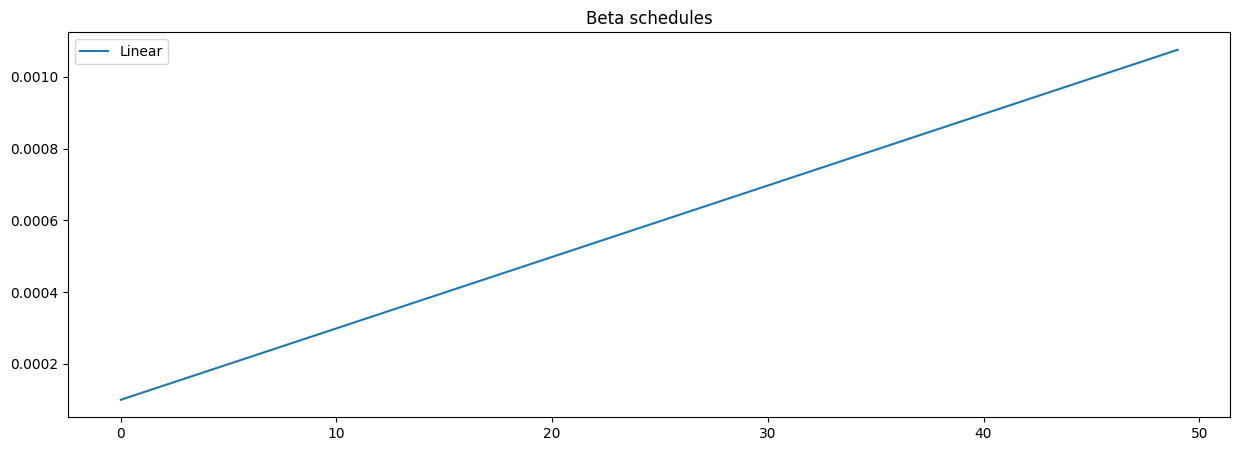

In [ ]:
def linear_beta_schedule(timesteps, start_scale=0.0001, end_scale=0.02):

    # A remplir pour avoir une beta linéaire entre start_scale et end_scale
    beta = torch.tensor(np.arange(start_scale, end_scale, (end_scale - start_scale)/timesteps))

    return beta

# plot beta schedules
plt.figure(figsize=(15, 5))
plt.plot(linear_beta_schedule(1000).detach().numpy()[:50])
plt.legend(["Linear"])
plt.title("Beta schedules")
plt.show()

Le resultat attendu est le suivant :
![image-2.png](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/beta_schedules.png)

#### 1) Diffusion avant

Cependant, comme nous n'avons besoin que de l'image à l'étape $t-1$ pour prédire l'image à l'étape $t$ lors de la diffusion, et que le bruit ajouté à chaque étape reste constant, nous pouvons rationaliser les calculs en générant l'image bruitée pour un instant spécifique. Cela nous permet de réduire la complexité du modèle et de simplifier le processus d'entraînement. Je vous saute les calculs, mais on obtient la formule suivante pour générer l'image à l'étape $t$ :
$$\alpha_{t}=1-\beta_{t} \text{ et } \overline{\alpha_{t}}=\prod_{i=0}^{t}a_{t}\\q(x_{t}|x_{0})=\mathcal{N}(x_{t};\sqrt{\overline{\alpha_t}}x_{0};(1-\overline{\alpha_t})I)$$

Pour obtenir $x_t$, on applique donc la formule suivante :
$$x_t=\sqrt{\overline{\alpha_t}}x_{0}+\sqrt{1-\overline{\alpha_t}}\epsilon_t$$

où $\epsilon_t$ est un bruit gaussien de moyenne nulle et de variance unitaire.

#### 2) Diffusion arrière

Par la suite, pour revenir en arrière, on cherche l'estimateur bayésien de la variance $\beta_t$ sachant $x_t$ et $x_0$, qui est donné par :
$$\widetilde{\beta}_t=\frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_t}\beta_t$$

De même pour la moyenne :
$$\widetilde{\mu}_t(x_t,x_0)=\frac{\sqrt{\overline{\alpha}_{t-1}}\beta_t}{1-\overline{\alpha}_t}x_0+\frac{\sqrt{\overline{\alpha}_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}x_t$$

On peut alors estimer $x_0$ à partir de $x_t$ en utilisant la formule suivante :
$$x_0=\frac1{\sqrt{\overline{\alpha_t}}}(x_t-\sqrt{1-\overline{\alpha_t}}\epsilon_t)$$

In [ ]:
class GaussianDiffusion:
    def __init__(self, timesteps=1000, beta_schedule="linear"):
        self.timesteps = timesteps

        if beta_schedule == "linear":
            betas = linear_beta_schedule(timesteps)
        else:
            raise ValueError(f"unknown beta schedule {beta_schedule}")
        self.betas = betas

        # calculs nécessaires pour plus tard (viens des formules de la partie diffusion avant notamment)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calcul de l'estimateur de la variance postérieure (viens des formules de la partie diffusion arrière)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # log variance tronquée car nulle au début
        self.posterior_log_variance_clipped = torch.log(
            self.posterior_variance.clamp(min=1e-20)
        )

        # calcul des coefficients de l'estimateur de la moyenne postérieure (viens des formules de la partie diffusion arrière)
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            torch.sqrt(self.alphas_cumprod) * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        # obtient le paramètre à un temps donné
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        # diffusion avant (utilise la propriété sympa): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start, device=x_start.device)

        sqrt_alphas_cumprod_t = self._extract(          # récupère les alphas cumulés à l'instant t
            self.sqrt_alphas_cumprod, t, x_start.shape
        ).to(x_start.device)
        sqrt_one_minus_alphas_cumprod_t = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_start.shape    # récupère les 1 - alphas cumulés à l'instant t
        ).to(x_start.device)

        x_t = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

        return x_t

    def q_mean_variance(self, x_start, t):
        # obtient la moyenne et la variance de q(x_t | x_0) (utiliser la partie diffusion avant)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start.shape
        )
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        # Calcul la moyenne et la variance de la diffusion postérieure q(x_{t-1} | x_t, x_0) (formules de la partie diffusion arrière)
        posterior_mean = (
            self.posterior_mean_coef1 * x_start + self.posterior_mean_coef2 * x_t
        )
        posterior_variance = self._extract(
            self.posterior_variance, t, x_start.shape
        )
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t, t, noise):
        # calcul x_0 depuis x_t et le bruit prédit: l'inverse de `q_sample` (utilise la partie diffusion arrière)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_t.shape)
        sqrt_recipm1_alphas_cumprod_t = self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

        x_0 = 1 / sqrt_alphas_cumprod_t * (x_t - sqrt_recipm1_alphas_cumprod_t * noise)

        return x_0

    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # calcul la moyenne et la variance prédits de p(x_{t-1} | x_t)

        pred_noise = model(x_t, t)      # bruit prédit par le modèle

        # Indice pour cette fonction : réutiliser q_posterior_mean_variance et predict_start_from_noise

        # Reconstruction de l'image grâce à x_t, t, et le bruit prédit par le modèle
        x_reconstructed = self.predict_start_from_noise(x_t, t, pred_noise)

        # On clip les valeurs de x_reconstructed entre -1 et 1
        if clip_denoised:
            x_reconstructed = torch.clamp(x_reconstructed, min=-1.0, max=1.0)

        # Calcul de la moyenne, de la variance et du log de la variance postérieure
        model_mean, posterior_variance, posterior_log_variance = (
            self.q_posterior_mean_variance(x_reconstructed, x_t, t)
        )

        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # Etape de débruitage : échantillonne x_{t-1} depuis x_t et le bruit prédit

        # Prédiction de la moyenne et de la variance de p(x_{t-1} | x_t)
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised)

        noise = torch.randn_like(x_t)           # bruit gaussien
        nonzero_mask = (t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))) # pas de bruit quand t == 0

        # Echantillonnage de x_{t-1} depuis x_t et le bruit prédit. S'estime à partir de la moyenne et de la variance prédites
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise #????????

        return pred_img

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        # Débruite : Diffusion inverse
        # Objectif : échantillonner x_0 depuis le bruit et renvoyez une liste d'images x_t pour chaque t
        batch_size = shape[0]
        device = next(model.parameters()).device

        imgs = []
        x_t = torch.randn(shape, device=device) # bruit initial

        for t in range(self.timesteps - 1, -1, -1): # On remonte le temps
            x_t = self.p_sample(model, x_t, torch.full((batch_size,), t, device=device)) # A remplir (penser à torch.full pour timesteps) #????torch.full
            imgs.append(x_t)

        return imgs

    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        # Créer de nouvelles images à partir du modèle
        return self.p_sample_loop(
            model, shape=(batch_size, channels, image_size, image_size)
        )

    def train_losses(self, model, x_start, t):
        # Calcul les loss d'entraînement
        # L'objectif ici est de comparer x_t-1 prédit à partir de x_t et x_t-1 réel.

        noise = torch.randn_like(x_start) # bruit gaussien

        noised_x = self.q_sample(x_start, t, noise) # bruit ajouté à x_t
        predicted_noise = model(noised_x, t) # bruit prédit par le modèle
        loss = F.mse_loss(predicted_noise, noise)
        return loss

### Test du sampler

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

%matplotlib inline

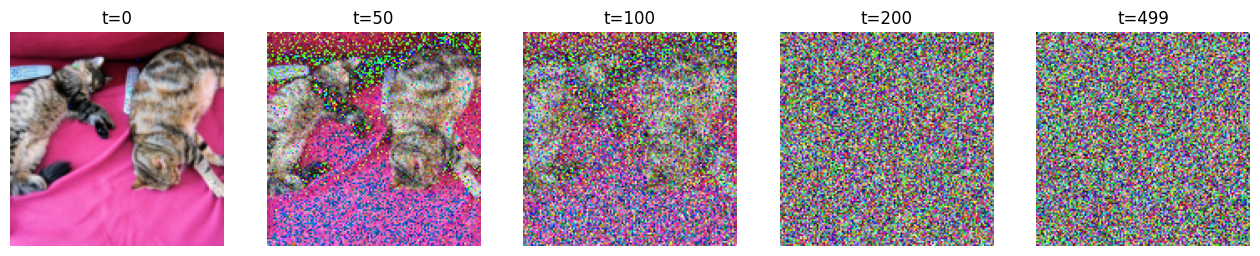

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_size = 128
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

Vous devez obtenir quelque chose de similaire à cela :
![image.png](https://raw.githubusercontent.com/Aul16/StableDiffusionTP/main/ddpm%20test.png)

### Mise en place de l'entraînement

Maintenant que l'on a notre modèle, on va pouvoir mettre en place l'entraînement. Pour cela, on va simplement entraîner le modèle sur les données que l'on a chargé précédemment. Je vous donne le code déjà rempli, ce TP est déjà assez dur comme ça et c'est pas le plus intéressant à faire.

In [ ]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
)

# use MNIST dataset
dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# define model and diffusion
timesteps = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, _ in tqdm(train_loader):
        x = x.to(device)
        t = torch.randint(0, timesteps, (x.shape[0],), device=device)
        optimizer.zero_grad()
        loss = gaussian_diffusion.train_losses(model, x, t)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"epoch {epoch + 1} train loss: {train_loss / len(train_loader)}")

# save the model
torch.save(model.state_dict(), "model.ckpt")

100%|██████████| 938/938 [06:27<00:00,  2.42it/s]


epoch 1 train loss: 0.05174036500757056


100%|██████████| 938/938 [06:23<00:00,  2.45it/s]


epoch 2 train loss: 0.03628915766162722


100%|██████████| 938/938 [06:23<00:00,  2.44it/s]


epoch 3 train loss: 0.0342307952540452


100%|██████████| 938/938 [06:25<00:00,  2.43it/s]


epoch 4 train loss: 0.03323015407013741


100%|██████████| 938/938 [06:23<00:00,  2.44it/s]

epoch 5 train loss: 0.032844366336952265


### Résultats

Enfin, on va pouvoir regarder les résultats obtenus par le modèle. Pareil je vous donne tout, c'est sympa à voir.

Enfin, on va pouvoir regarder les résultats obtenus par le modèle. Pareil je vous donne tout, c'est sympa à voir.

In [ ]:
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
)
model.load_state_dict(torch.load("model.ckpt", map_location=device))

model.to(device)
model.eval()

UNetModel(
  (time_embed): Time_Embedding(
    (layers): Sequential(
      (0): Linear(in_features=96, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
    )
  )
  (down_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): TimestepEmbedSequential(
        (0): ResidualBlock(
          (conv1): Sequential(
            (0): GroupNorm(32, 96, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb): Sequential(
            (0): SiLU()
            (1): Linear(in_features=384, out_features=96, bias=True)
          )
          (conv2): Sequential(
            (0): GroupNorm(32, 96, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Con

In [ ]:
image_size = 28
sampled_images = gaussian_diffusion.sample(model, image_size, batch_size=64, channels=1)

RuntimeError: The size of tensor a (500) must match the size of tensor b (28) at non-singleton dimension 3

In [ ]:
# generate new images

NROWS = 8
NCOLS = 8
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(NROWS, NCOLS)

generated_images = sampled_images.copy()

imgs = (
    generated_images[-1]
    .cpu()
    .squeeze()
    .detach()
    .numpy()
    .reshape(NROWS, NCOLS, image_size, image_size)
)
for n_row in range(NROWS):
    for n_col in range(NCOLS):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col] + 1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [ ]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = (
            generated_images[t_idx]
            .cpu()
            .squeeze()
            .detach()
            .numpy()[n_row]
            .reshape(28, 28)
        )
        f_ax.imshow((img + 1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [ ]:
x_start = torch.tensor(generated_images[-1][0], device=device)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().cpu().detach().numpy().reshape(28, 28) + 1) * 127.5
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image, cmap="gray")
    plt.axis("off")
    plt.title(f"t={t}")